In [5]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/multi_agent_sim")
from multi_agent_sim import MultiAgentSim

In [6]:
import re
def extract_sim_properties(filename):
    # remove pickle extension and brackets
    key_name = filename.split('.pickle')[0]
    key_name = key_name.split('/')[-1]
    base_fname = re.sub('[()]', '', key_name)
    properties = base_fname.split(',')
    R0 = float(properties[0])
    at_mult = float(properties[1])
    st_freq = float(properties[2])
    use_at = (properties[3].strip() == 'True')
    use_st = (properties[4].strip() == 'True')
    return (R0, at_mult, st_freq, use_at, use_st)


import pickle as pickle
def load_sim_output(fname):
    with open(fname, "rb") as handle:
        sim_output = pickle.load(handle)
    return sim_output


def trajectory_data(trajectory):
    total_tests = trajectory[0]
    infection_counts = trajectory[1]
    init_infection_counts = trajectory[2]
    final_infection_counts = trajectory[3]
    return total_tests, infection_counts, init_infection_counts, final_infection_counts

def load_sim_outputs(sim_output_dir):
    sim_pickle_files = [sim_output_dir + '/' + file for  file in os.listdir(sim_output_dir) if ').pickle' in file]


    sim_outputs = {}
    for fname in sim_pickle_files:
        sim_properties = extract_sim_properties(fname)
        sim_output = load_sim_output(fname)
        sim_outputs[sim_properties] = sim_output

    print("Loaded {} simulation results".format(len(sim_outputs)))
    return sim_outputs

In [11]:
a

(1, 2, 3, 4, 5)

Loaded 268 simulation results
Loaded 268 simulation results


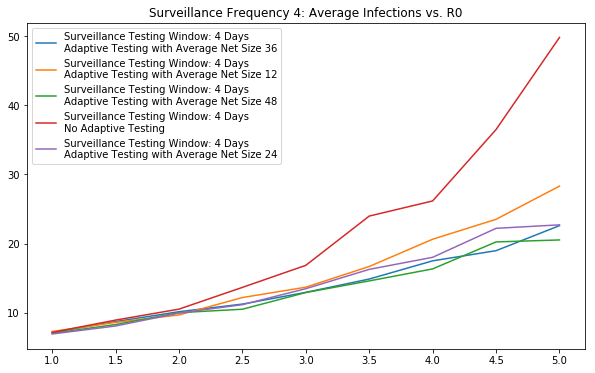

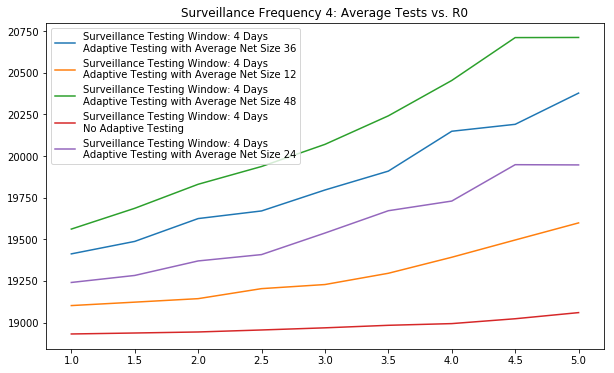

Loaded 268 simulation results
Loaded 268 simulation results


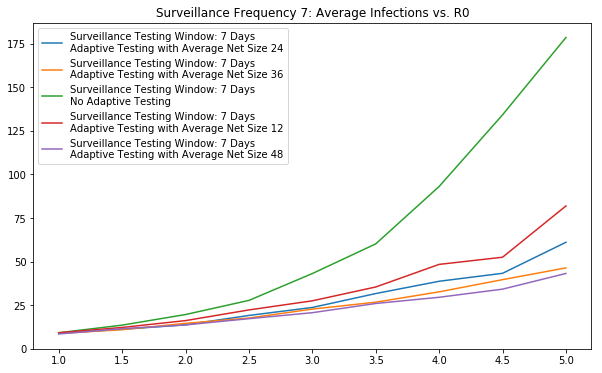

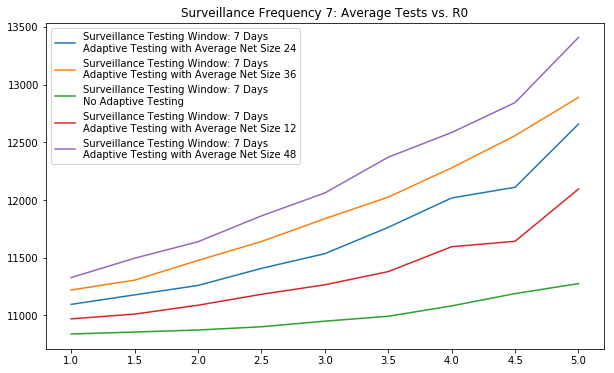

Loaded 268 simulation results
Loaded 268 simulation results


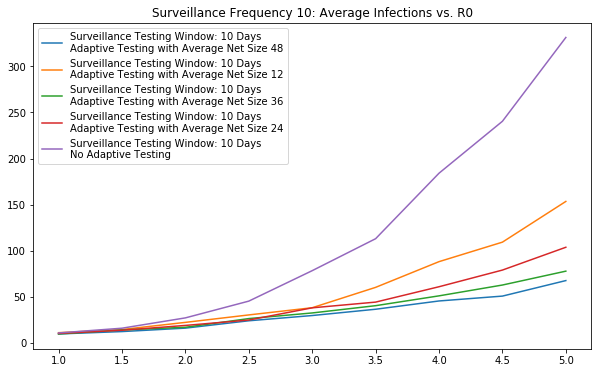

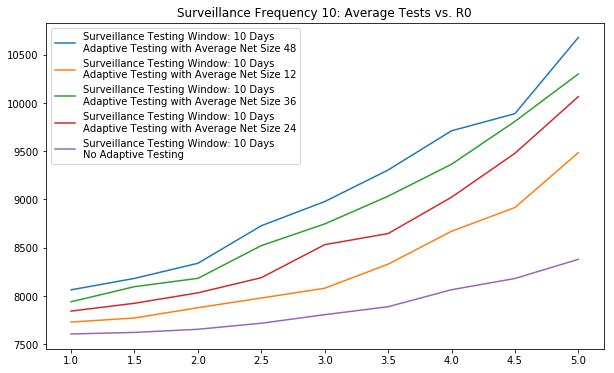

Loaded 268 simulation results
Loaded 268 simulation results


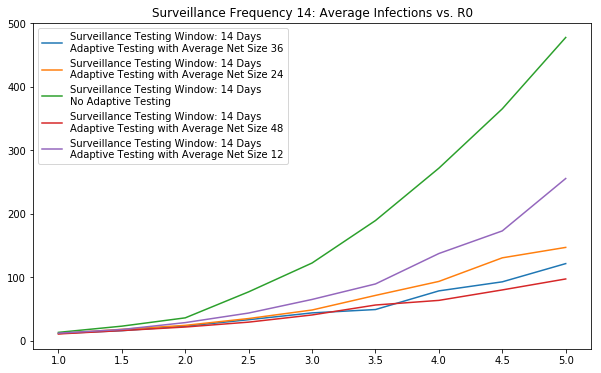

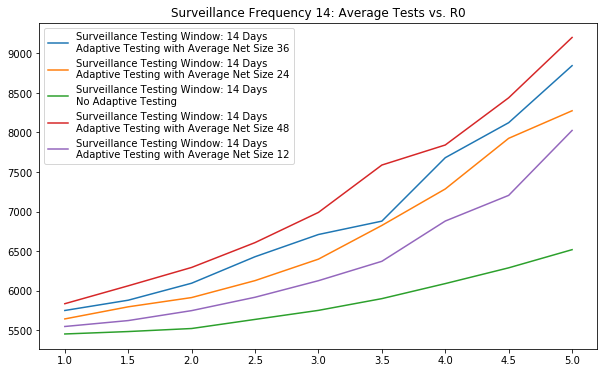

Loaded 268 simulation results
Loaded 268 simulation results


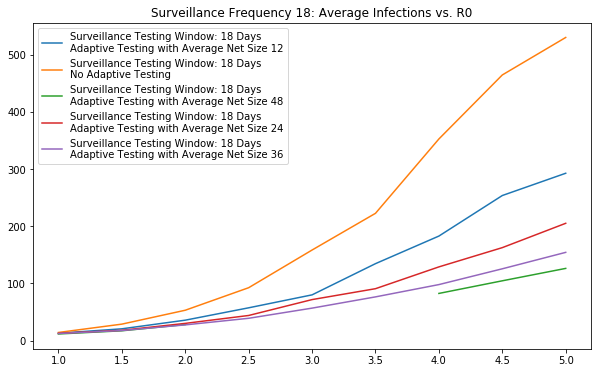

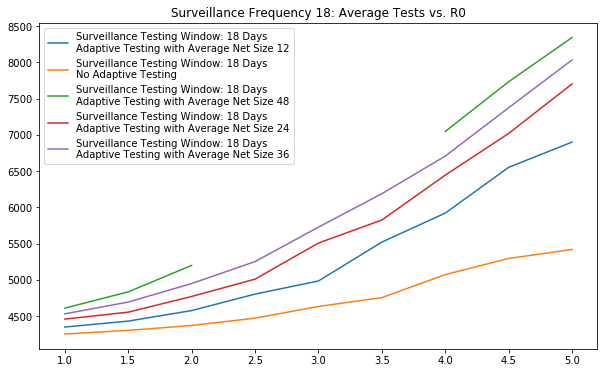

"  \nplot_resources_vs_R0('./jan_07_multiagent_sims/', \n                     policy_subset=[(1.0, 14.0, False, True), \n                                    (8.0, 14.0, True, True),\n                                    (1.0, 7.0, False, True),\n                                    (8.0, 7.0, True, True)])\n            \nplot_resources_vs_R0('./jan_07_multiagent_sims/')\n            \n"

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

# create scatter plot of tests vs. infections

def get_avg_tests(sim_output):
    return np.mean([traj[0] for traj in sim_output])

def get_avg_infxns(sim_output):
    return np.mean([traj[-1] for traj in sim_output])

def tests_vs_infxns_plot(R0, sim_outputs):
    no_at_test_counts = []
    no_at_infxn_counts = []
    uses_at_test_counts = []
    uses_at_infxn_counts = []
    for sim_properties, sim_output in sim_outputs.items():
        if sim_properties[0] != R0:
            continue
        if not sim_properties[-1]:
            continue
        uses_at = sim_properties[3]
        
        total_tests = get_avg_tests(sim_output)
        total_infxns = get_avg_infxns(sim_output)
        
        if uses_at:
            uses_at_test_counts.append(total_tests)
            uses_at_infxn_counts.append(total_infxns)
        else:
            no_at_test_counts.append(total_tests)
            no_at_infxn_counts.append(total_infxns)
    
    plt.figure(figsize=(10,6))
    plt.scatter(uses_at_test_counts, uses_at_infxn_counts, label='Using Adaptive and Surveillance Testing')
    plt.scatter(no_at_test_counts, no_at_infxn_counts, label='Surveillance Testing Only')
    plt.title('Testing vs. Infections Tradeoff from Simulations with R0={}'.format(R0))
    plt.legend(loc='best')
    plt.show()
    
def make_test_vs_infxns_plots(sim_output_dir):
    sim_outputs = load_sim_outputs(sim_output_dir)

    all_R0s = sorted(list(set([p[0] for p in sim_outputs])))
    for R0 in all_R0s:
        tests_vs_infxns_plot(R0, sim_outputs)
           
def get_simulated_R0s(sim_outputs):
    R0s = set()
    for sim_properties in sim_outputs:
        R0s.add(sim_properties[0])
    return sorted(list(R0s))

def get_simulated_policies(sim_outputs):
    policies = set()
    for sim_properties in sim_outputs:
        policies.add(sim_properties[1:])
    return policies


def get_policy_label(policy):
    surveillance_part = "Surveillance Testing Window: {} Days".format(int(policy[1]))
    
   
    if not policy[2]:
        adaptive_part = "No Adaptive Testing"
    else:
        adaptive_part = "Adaptive Testing with Average Net Size {}".format(3 * int(policy[0]))
    
    return surveillance_part + "\n" + adaptive_part


def plot_resources_vs_R0(sim_output_dir, policy_subset=None, titlestr=""):
    sim_outputs = load_sim_outputs(sim_output_dir)
    R0s = get_simulated_R0s(sim_outputs)
    
    
    
    if policy_subset == None:
        policies = get_simulated_policies(sim_outputs)
    else:
        policies = get_simulated_policies(sim_outputs).intersection(policy_subset)
        
    policy_avg_infxns = {policy:[] for policy in policies}
    policy_avg_tests = {policy:[] for policy in policies}
    
    for policy in policies:
        
        
        for R0 in R0s:
            sim_properties = (R0, *policy)
            if sim_properties not in sim_outputs:
                policy_avg_infxns[policy].append(None)
                policy_avg_tests[policy].append(None)
            else:
                sim_output = sim_outputs[sim_properties]
                policy_avg_infxns[policy].append(get_avg_infxns(sim_output))
                policy_avg_tests[policy].append(get_avg_tests(sim_output))
    
    
    plt.figure(figsize=(10,6))
    for policy in policies:
        plt.plot(R0s, policy_avg_infxns[policy], label=get_policy_label(policy))
    plt.title("{} Average Infections vs. R0".format(titlestr))
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(10,6))
    for policy in policies:
        plt.plot(R0s, policy_avg_tests[policy], label=get_policy_label(policy))
    plt.title("{} Average Tests vs. R0".format(titlestr))
    plt.legend(loc='best')
    plt.show()
    

def get_subset_of_policies(sim_output_dir, surveillance_freq):
    policies = get_simulated_policies(load_sim_outputs(sim_output_dir))
    subset_policies = set()
    for policy in policies:
        if int(policy[1]) == surveillance_freq:
            subset_policies.add(policy)
    return subset_policies

surveillance_freqs = [4,7,10,14,18]
for surveillance_freq in surveillance_freqs:
    subset = get_subset_of_policies('./jan_07_multiagent_sims/', surveillance_freq)
    plot_resources_vs_R0('./jan_07_multiagent_sims/', subset, 'Surveillance Frequency {}:'.format(surveillance_freq))
"""  
plot_resources_vs_R0('./jan_07_multiagent_sims/', 
                     policy_subset=[(1.0, 14.0, False, True), 
                                    (8.0, 14.0, True, True),
                                    (1.0, 7.0, False, True),
                                    (8.0, 7.0, True, True)])
            
plot_resources_vs_R0('./jan_07_multiagent_sims/')
            
"""

Loaded 268 simulation results


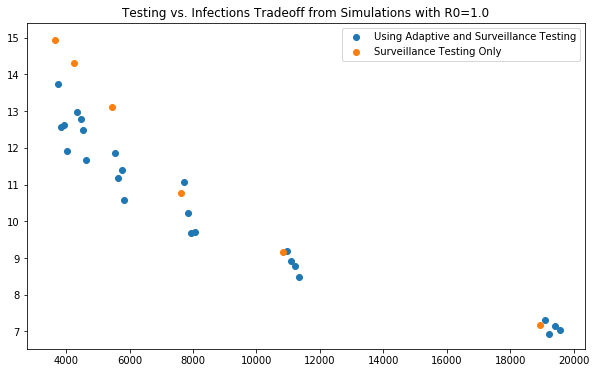

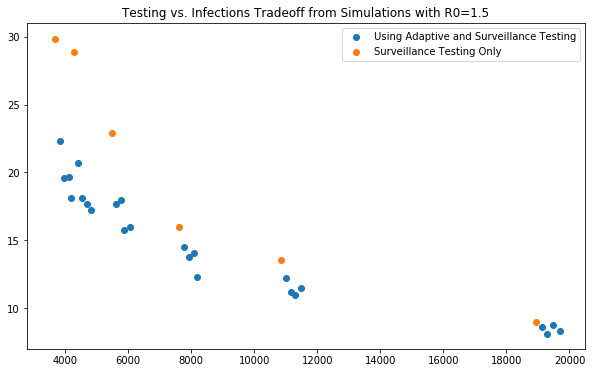

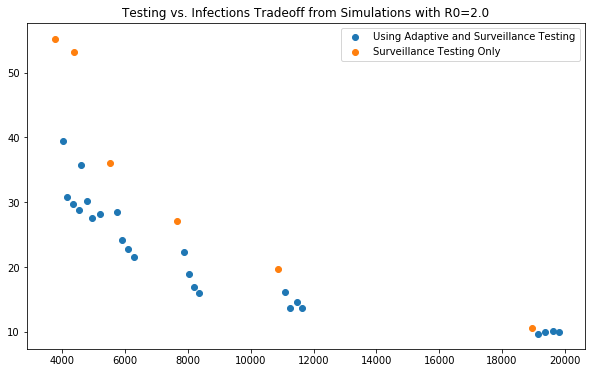

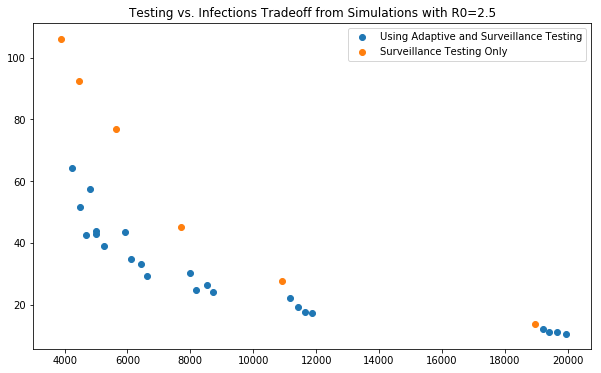

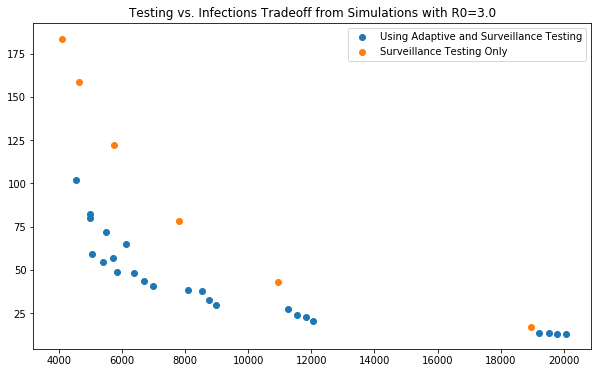

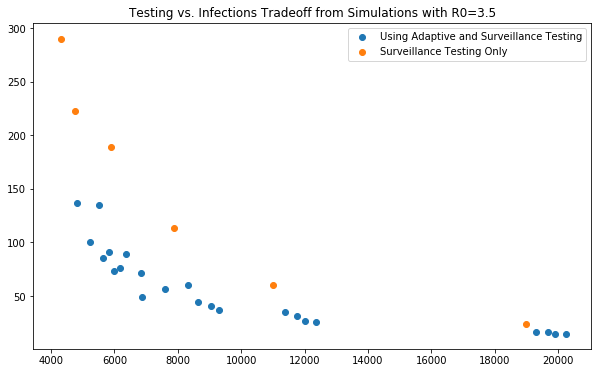

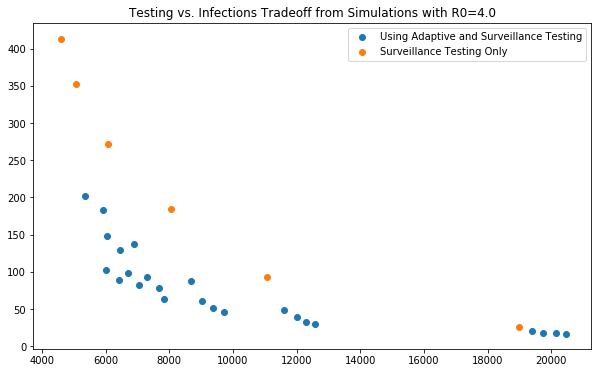

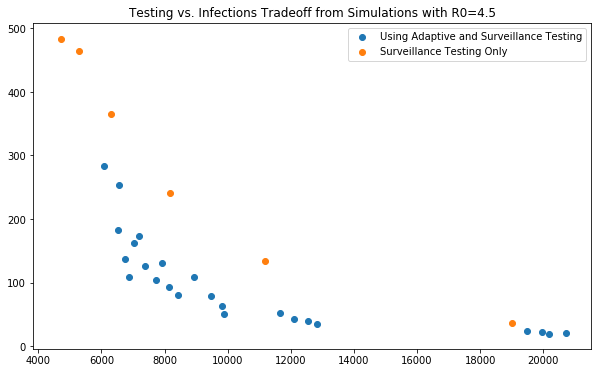

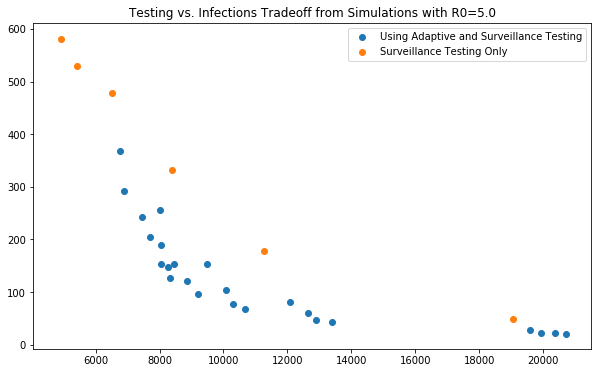

In [27]:
make_test_vs_infxns_plots('./jan_07_multiagent_sims/')

Loaded 268 simulation results


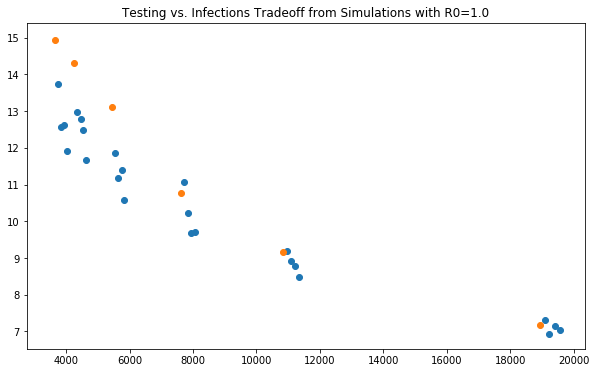

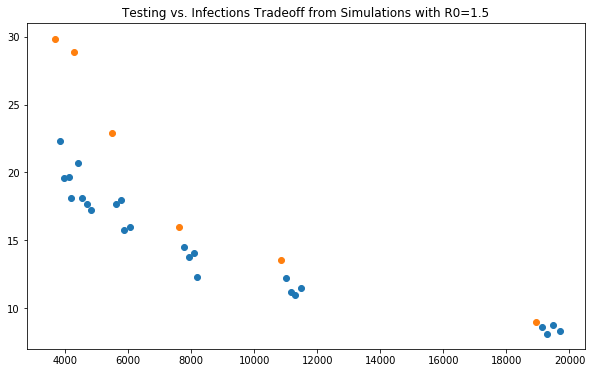

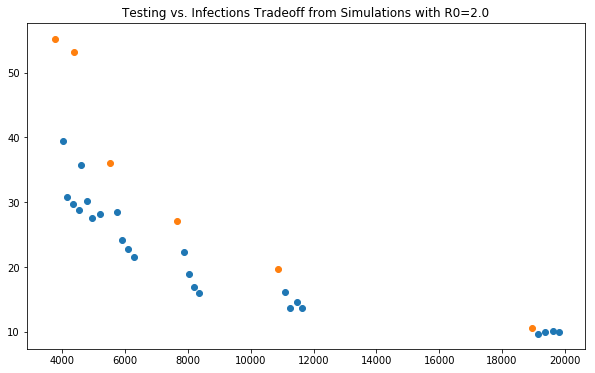

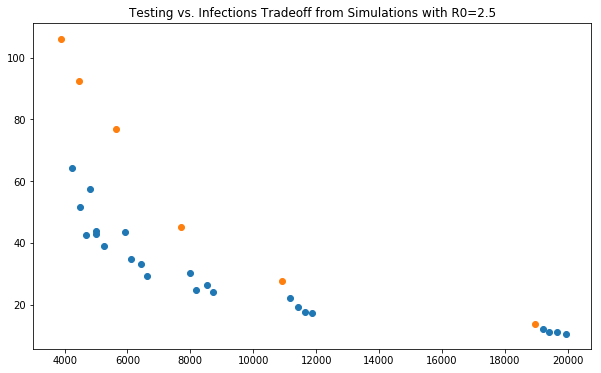

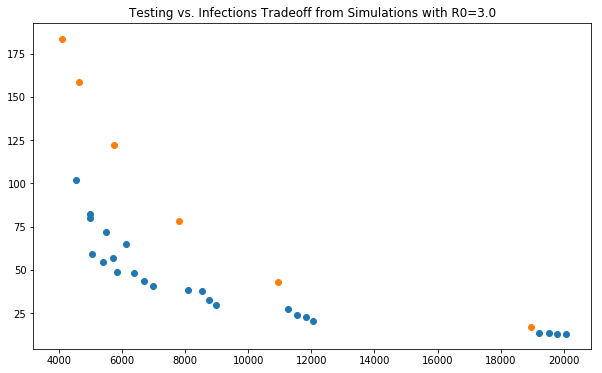

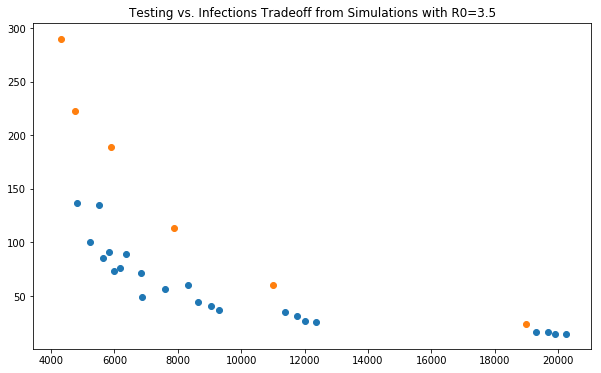

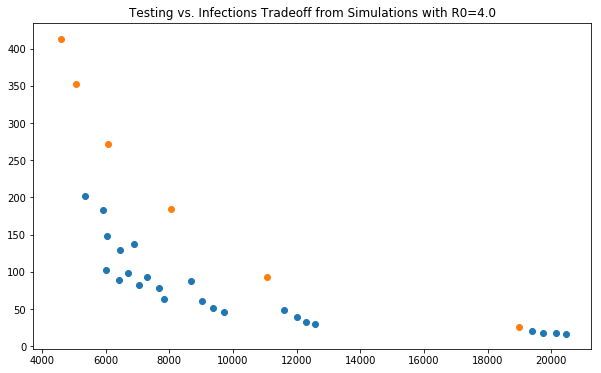

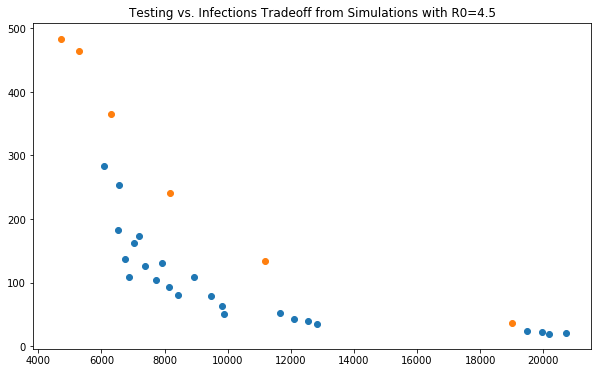

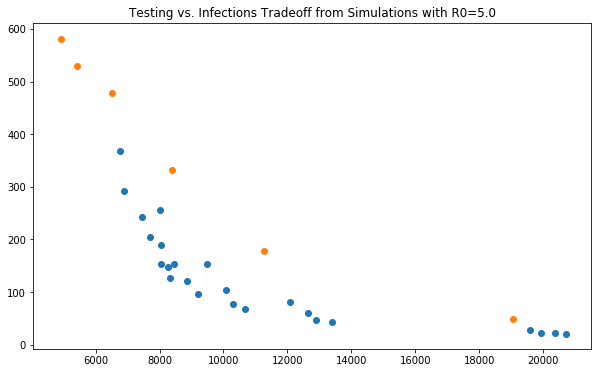

In [9]:
make_test_vs_infxns_plots('./jan_07_multiagent_sims/')

In [34]:
sim_output = sim_outputs[(3.5, (12.0, 4.0, True, True))]

In [35]:
sim_output

[(19526,
  [0,
   0,
   1,
   1,
   1,
   1,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   2,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   3,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4,
   4],
  0,
  4),
 (19628,
  [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   2,
   2,
   2,
   2,
   2,
   2,
   3,
   3,
   4,
   4,
   4,
   5,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7

In [15]:
len(sim)

250

In [10]:
fname = "(1, (10, 7, True, True)).pickle_v2"
fname.strip('(')

'1, (10, 7, True, True)).pickle_v2'

In [4]:
'(2)'.strip('(').strip(')')

'2'